<a href="https://colab.research.google.com/github/wihr1980/ab_tests/blob/main/14_%D0%A1%D0%B1%D0%BE%D1%80%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_03_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A / B  Тестирование 

###  Постановка задачи

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:
- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Загрузим необходимые модули

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import plotly.express as px
import math as mth
import re
import scipy.stats as stats
import warnings
import requests

from plotly import graph_objects as go
from google.colab import files
from matplotlib import pyplot as plt
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
from datetime import datetime, timedelta

register_matplotlib_converters()
warnings.filterwarnings("ignore")

## Загрузим датасеты из файлов

In [2]:
try:
    print('Загружаем локально...')
    final_ab_events = pd.read_csv('/final_ab_events.csv')
    ab_project_marketing_events = pd.read_csv('/ab_project_marketing_events.csv')
    final_ab_new_users = pd.read_csv('/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('/final_ab_participants.csv')    
except:
    print('Локально не нашли, загружаем с сервера...')
    final_ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    ab_project_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    final_ab_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv') 
print('Done')

Загружаем локально...
Локально не нашли, загружаем с сервера...
Done


## Исследуем данные

In [3]:
print(final_ab_events.info())
print('Количество NAN final_ab_events',final_ab_events.isna().sum())
print('Количество дублей final_ab_events',final_ab_events.duplicated().sum())
print()
print(ab_project_marketing_events.info())
print('Количество NAN ab_project_marketing_events',ab_project_marketing_events.isna().sum())
print('Количество дублей ab_project_marketing_events',ab_project_marketing_events.duplicated().sum())
print()
print(final_ab_new_users.info())
print('Количество NAN final_ab_new_users',final_ab_new_users.isna().sum())
print('Количество дублей final_ab_new_users',final_ab_new_users.duplicated().sum())
print('Количество дублей final_ab_new_users',final_ab_new_users.duplicated(['user_id']).sum())

print()
print(final_ab_participants.info())
print('Количество NAN final_ab_participants',final_ab_participants.isna().sum())
print('Количество дублей final_ab_participants',final_ab_participants.duplicated().sum())
print()
print('Начало измериняия final_ab_events',final_ab_events['event_dt'].min())
print('Окончание измериняия final_ab_events',final_ab_events['event_dt'].max())
print()
print('Начало измериняия final_ab_new_users',final_ab_new_users['first_date'].min())
print('Окончание измериняия final_ab_new_users',final_ab_new_users['first_date'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
Количество NAN final_ab_events user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Количество дублей final_ab_events 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
Количество NAN ab_project_mar

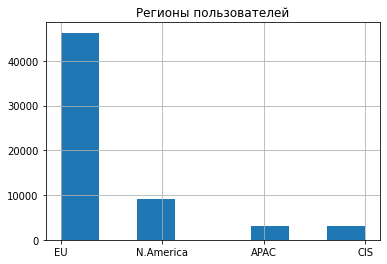

In [4]:
plt.title('Регионы пользователей')
final_ab_new_users['region'].hist(bins=final_ab_new_users['region'].nunique()*2);

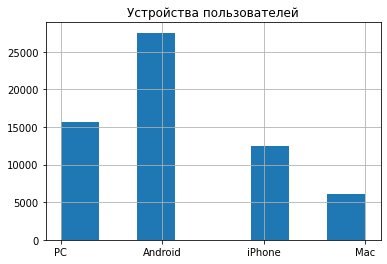

In [5]:
plt.title('Устройства пользователей')
final_ab_new_users['device'].hist(bins=final_ab_new_users['device'].nunique()*2);

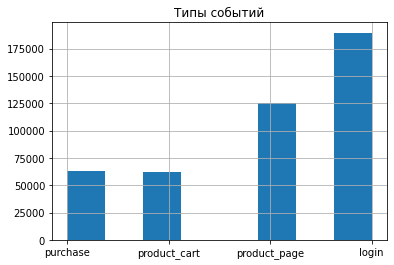

In [6]:
plt.title('Типы событий')
final_ab_events['event_name'].hist(bins=final_ab_events['event_name'].nunique()*2);

In [7]:
final_ab_participants.duplicated(['user_id']).sum()

1602

In [8]:
final_ab_participants.duplicated(['user_id','group']).sum()

826

### Вывод 

Нужно привести даты в правильный формат
final_ab_new_users['details'] есть nan , но это сказано в условиях, что это дополнительная информация. которой может не быть

## Даты в правильный формат

In [9]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])



## Оцените корректность проведения теста. Обратите внимание на:

### Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.




In [10]:
n_users = final_ab_new_users['user_id'].nunique()
ue_users = final_ab_new_users.query('region=="EU"')['user_id'].nunique()
print(n_users,ue_users, ue_users/n_users)

61733 46270 0.7495180859507881


- Название теста: `recommender_system_test`; ✔️ ОК
- группы: А — контрольная, B — новая платёжная воронка; ✔️ OK
- дата запуска: 2020-12-07; ✔️ OK
- дата остановки набора новых пользователей: 2020-12-21; ❌ **Not OK**
- дата остановки: 2021-01-04; ❌ **Not OK**
- аудитория: 15% новых пользователей из региона EU;  ✔️ OK
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы; ✔️ OK
- ожидаемое количество участников теста: 6000. ✔️ OK
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`, ❌ **Not OK**
    - просмотры корзины — `product_cart`, ❌ **Not OK**
    - покупки — `purchase`. ❌ **Not OK**

### Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

In [11]:
ev_dt_max = final_ab_events['event_dt'].max()
ev_dt_min = final_ab_events['event_dt'].min()

for i , j in ab_project_marketing_events[ab_project_marketing_events['regions'].str.contains(r'\bEU')].iterrows():
   if((j['start_dt']<ev_dt_min)and(j['finish_dt']>ev_dt_min))\
       or ((j['start_dt']<ev_dt_max)and(j['finish_dt']>ev_dt_max))\
       or ((j['start_dt']>ev_dt_min)and(j['finish_dt']<ev_dt_max)):
       print('Акция ', j['name'] , j['start_dt'], j['finish_dt'], 'попадает на период тестирования')

Акция  Christmas&New Year Promo 2020-12-25 00:00:00 2021-01-03 00:00:00 попадает на период тестирования


На веремя проведелния теста в Европе приходиться акция  Christmas&New Year Promo. Но эта акция скорее всего влияет на обе группы исследуемых одинаково, поэтому этим фактом можно пренебречь

###  Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

In [12]:
both_test_users = final_ab_participants.pivot_table(index=['user_id'], values='ab_test', aggfunc='nunique')
both_g_users = final_ab_participants.pivot_table(index=['user_id'], values='group', aggfunc='nunique')
print('Количество пользователей',final_ab_participants['user_id'].nunique())
print('Пользователи в нескольких тестах',len(both_test_users[both_test_users['ab_test'] > 1]))
print('Пользователи в нескольких группах',len(both_g_users[both_g_users['group'] > 1]))

Количество пользователей 16666
Пользователи в нескольких тестах 1602
Пользователи в нескольких группах 776


## Оставим только recommender_system_test

In [13]:
final_ab_participants = final_ab_participants.query('ab_test=="recommender_system_test"')

In [14]:
both_test_users = final_ab_participants.pivot_table(index=['user_id'], values='ab_test', aggfunc='nunique')
both_g_users = final_ab_participants.pivot_table(index=['user_id'], values='group', aggfunc='nunique')
print('Количество пользователей',final_ab_participants['user_id'].nunique())
print('Пользователи в нескольких тестах',len(both_test_users[both_test_users['ab_test'] > 1]))
print('Пользователи в нескольких группах',len(both_g_users[both_g_users['group'] > 1]))

Количество пользователей 6701
Пользователи в нескольких тестах 0
Пользователи в нескольких группах 0


## Проверьте равномерность распределения по тестовым группам и правильность их формирования.

In [15]:
users_g = final_ab_participants.pivot_table(index=['group'], values='user_id', aggfunc='count')
fig = px.pie(users_g, values='user_id', width=400, names=users_g.index, title='Разделение по группам')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show();

## Проведите исследовательский анализ данных:

### Создадим профиль пользователей

In [16]:
log = final_ab_participants.merge(final_ab_events, on='user_id')
log = log.merge(final_ab_new_users, on='user_id')

### Количество событий на пользователя одинаково распределены в выборках?

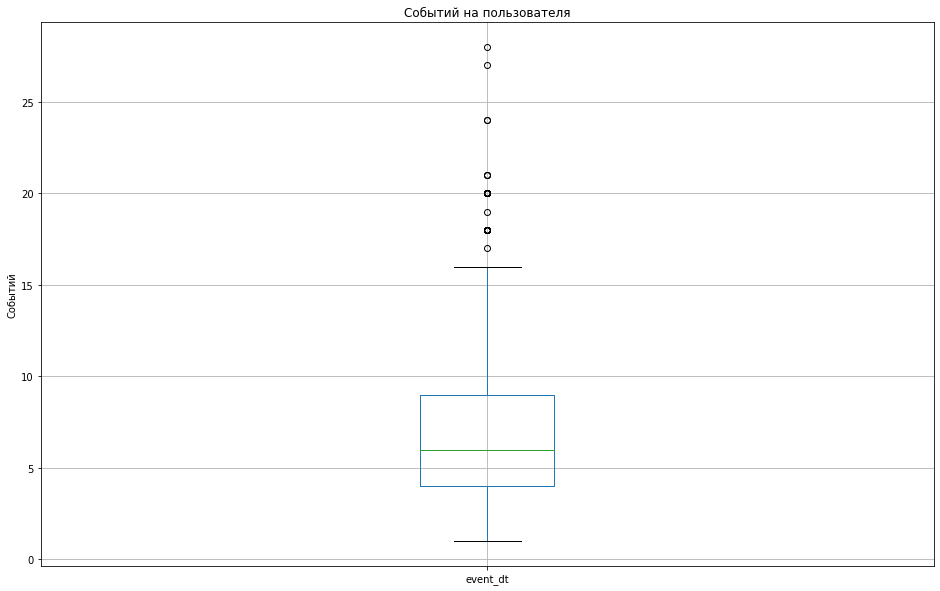

In [17]:
log_users = log.pivot_table(index=['user_id'], values=['event_dt'], aggfunc='count')
plt.figure(figsize=(16, 10))
plt.ylabel('Событий')
plt.title('Событий на пользователя')
log_users.boxplot();

### Как число событий в выборках распределено по дням?

Построим гистограмму по времени

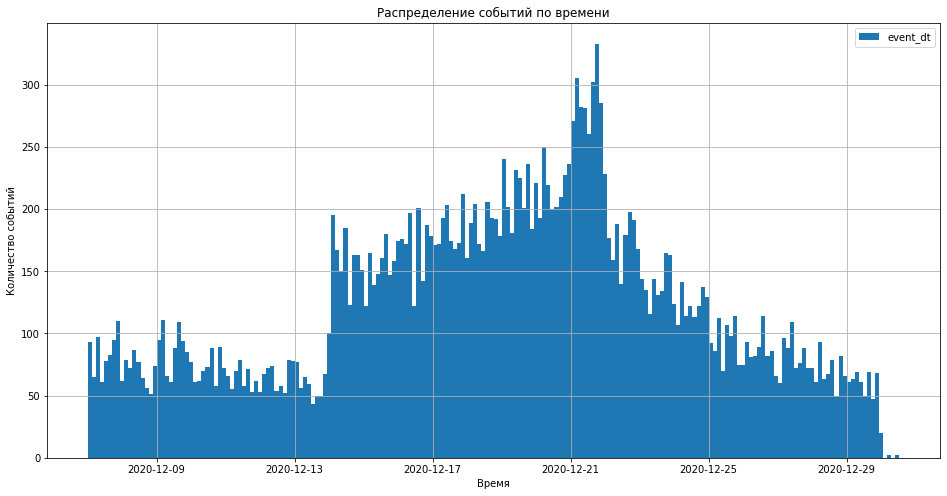

In [18]:
log['event_dt'].hist(figsize=(16, 8),bins = 200,legend=True);
plt.title('Распределение событий по времени')
plt.ylabel('Количество событий')
plt.xlabel('Время')
plt.show()

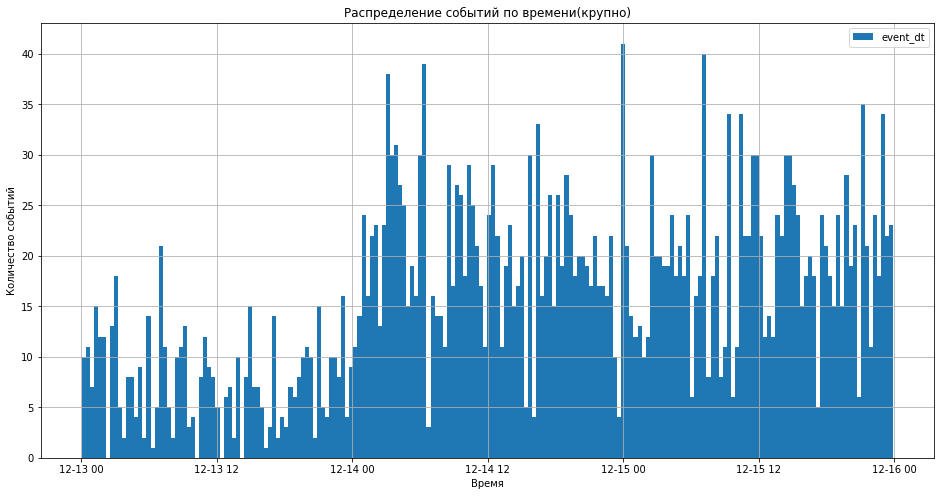

In [19]:
log.query('event_dt>="2020-12-13" & event_dt<="2020-12-16"')['event_dt'].hist(figsize=(16, 8),bins=200,legend=True);
plt.title('Распределение событий по времени(крупно)')
plt.ylabel('Количество событий')
plt.xlabel('Время')
plt.show()

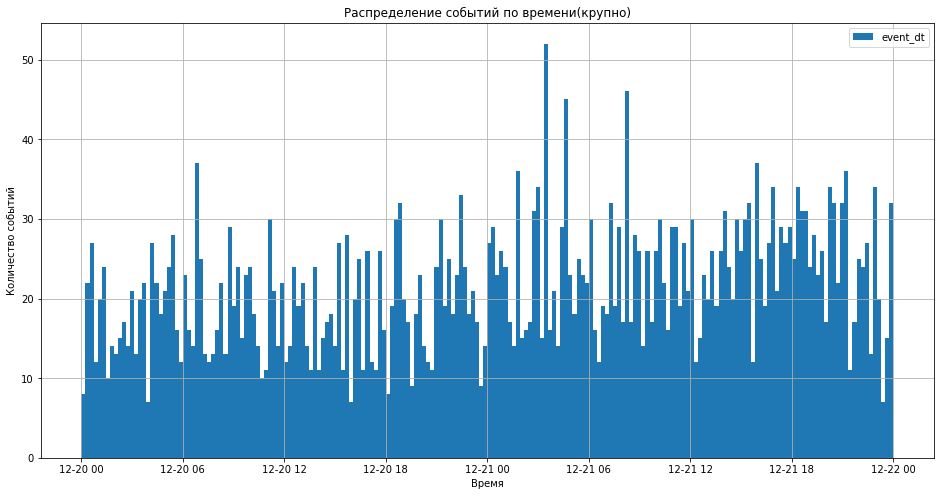

In [20]:
log.query('event_dt>="2020-12-20" & event_dt<="2020-12-22"')['event_dt'].hist(figsize=(16, 8),bins=200,legend=True);
plt.title('Распределение событий по времени(крупно)')
plt.ylabel('Количество событий')
plt.xlabel('Время')
plt.show()

### Как меняется конверсия в воронке в выборках на разных этапах?

In [21]:
funnel_ab = log.pivot_table(index=['event_name'], values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)
funnel_a = log.query('group=="A"').pivot_table(index=['event_name'], values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)
funnel_b = log.query('group=="B"').pivot_table(index=['event_name'], values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

fig = go.Figure(go.Funnel(
    y = funnel_ab.index, 
    x = funnel_ab['user_id'],
    textinfo = "value+percent initial + percent previous",
    marker = {"color": ["deepskyblue", "deepskyblue", "deepskyblue"]},
    ))
fig.update_layout(title="Воронка для А и В")
fig.show()

In [22]:
fig = go.Figure(go.Funnel(
    y = funnel_a.index, 
    x = funnel_a['user_id'],
    textinfo = "value+percent initial + percent previous",
    marker = {"color": ["lightsalmon", "lightsalmon", "lightsalmon"]},
    ))
fig.update_layout(title="Воронка для А ")
fig.show()

In [23]:
fig = go.Figure(go.Funnel(
    y = funnel_b.index, 
    x = funnel_b['user_id'],
    textinfo = "value+percent initial + percent previous",
    marker = {"color": ["tan", "tan", "tan"]},
    ))
fig.update_layout(title="Воронка для В")
fig.show()

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?


Почему то покупок меньше чем добавлений в корзину. Я не знаю что с этим делать

## Оцените результаты A/B-тестирования

In [24]:
funnel_ab = funnel_ab.merge(funnel_a, on='event_name').merge(funnel_b, on='event_name').reset_index()
funnel_ab.columns = ['event','a_b','a','b']

for i in funnel_ab.index:
    if i>0:
        funnel_ab.loc[[i], ['a_b_CR']] = funnel_ab.loc[i]['a_b'] / funnel_ab.loc[0]['a_b'] *100
        funnel_ab.loc[[i], ['a_CR']] = funnel_ab.loc[i]['a'] / funnel_ab.loc[0]['a'] *100
        funnel_ab.loc[[i], ['b_CR']] = funnel_ab.loc[i]['b'] / funnel_ab.loc[0]['b'] *100
    else:
        funnel_ab.loc[[i], ['a_b_CR']] = 100
        funnel_ab.loc[[i], ['a_CR']] = 100
        funnel_ab.loc[[i], ['b_CR']] = 100        
        
print(funnel_ab)  

          event    a_b     a     b      a_b_CR        a_CR        b_CR
0         login  11190  8566  2624  100.000000  100.000000  100.000000
1  product_page   6930  5525  1405   61.930295   64.499183   53.544207
2      purchase   3331  2655   676   29.767650   30.994630   25.762195
3  product_cart   3247  2558   689   29.016979   29.862246   26.257622


### Вывод 

Конверсия даже уменьшилась в группе Б. И естественно нигде не достигла прироста в 10%

### Гипотеза

Нулевая гипотеза: конверсия пользователей из группы A и группы B одинаковая 

### Проверьте статистическую разницу долей z-критерием.

In [25]:
# Уровень значимости возьмем 0,05
alpha = .05 

In [26]:
# процедура сасчитывает статистическую  значимость разницы(взял ее из тренажера)
def z_val(successes,trials):
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('P-value',p_value)
    return p_value

### Проверим воронки

In [27]:
# Заполняем параметры и вызываем процедуру        
g1 = 'a'
g2 = 'b'
trials = np.array([funnel_ab.loc[0,g1], funnel_ab.loc[0,g2]])
for i in funnel_ab.index:
    if i>0:
        successes = np.array([funnel_ab.loc[i,g1], funnel_ab.loc[i,g2]])
        print()
        print('Группы',g1,g2,'Проверяем событие',funnel_ab.loc[i, 'event'])
        if z_val(successes,trials)  < alpha:
            print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группами разными')       


Группы a b Проверяем событие product_page
P-value 0.0
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы a b Проверяем событие purchase
P-value 2.9153832015182957e-07
Отвергаем нулевую гипотезу: между группами есть значимая разница

Группы a b Проверяем событие product_cart
P-value 0.00037128846600120724
Отвергаем нулевую гипотезу: между группами есть значимая разница


### Проверим CR

In [28]:
g1 = 'a_CR'
g2 = 'b_CR'
trials = np.array([funnel_ab.loc[0,g1], funnel_ab.loc[0,g2]])
for i in funnel_ab.index:
    if i>0:
        successes = np.array([funnel_ab.loc[i,g1], funnel_ab.loc[i,g2]])
        print()
        print('Группы',g1,g2,'Проверяем событие',funnel_ab.loc[i, 'event'])
        if z_val(successes,trials)  < alpha:
            print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группами разными')    


Группы a_CR b_CR Проверяем событие product_page
P-value 0.11522880461263973
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группами разными

Группы a_CR b_CR Проверяем событие purchase
P-value 0.4118296871949043
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группами разными

Группы a_CR b_CR Проверяем событие product_cart
P-value 0.5705073010777988
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группами разными


## Итог 

Опишите выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста.

Был проведен аб тест, корректность его проведения вызывает сомнение.  Он проходит во время акции, также некоторые пользователи, учавствующие в тесте, учавствовали в другом тесте.

Акция влияла сразу на всех пользователей и, ей можно пренебречь.

по всем трем событиям не получилось отвергнуть нулевую гипотезу, нет оснований считать группами разными.

Внедрение изменения нецелесообразно.